In [1]:
import pandas as pd
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time

In [2]:
sns.set_theme()

In [3]:
# mock product data as a list of dictionaries
product_data = [
    {
        "name": "Boho Dress",
        "desc": "Flowy, earthy tones for festival vibes.",
        "vibes": ["boho", "festival", "cozy"]
    },
    {
        "name": "Noise-Canceling Headphones",
        "desc": "Sleek, over-ear design for immersive sound.",
        "vibes": ["tech", "modern", "focus"]
    },
    {
        "name": "Chunky Knit Blanket",
        "desc": "Oversized and soft, perfect for a rainy day.",
        "vibes": ["cozy", "home", "hygge"]
    },
    {
        "name": "Performance Joggers",
        "desc": "Lightweight, stretch-fit for gym or lounge.",
        "vibes": ["athletic", "athleisure", "comfy"]
    },
    {
        "name": "Minimalist Watch",
        "desc": "Simple, elegant timepiece with a leather strap.",
        "vibes": ["minimalist", "classic", "elegant"]
    },
    {
        "name": "RGB Mechanical Keyboard",
        "desc": "Clicky switches and customizable backlighting.",
        "vibes": ["gaming", "tech", "rgb"]
    },
    {
        "name": "Insulated Tumbler",
        "desc": "Keeps drinks cold for 24 hours. Trail-ready.",
        "vibes": ["outdoor", "utility", "durable"]
    },
    {
        "name": "Linen Button-Down",
        "desc": "Breathable, crisp shirt for a timeless look.",
        "vibes": ["classic", "preppy", "summer"]
    }
]

# Pandas DataFrame from the data
df = pd.DataFrame(product_data)

In [4]:
df.head()

,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones for festival vibes.","[boho, festival, cozy]"
1,Noise-Canceling Headphones,"Sleek, over-ear design for immersive sound.","[tech, modern, focus]"
2,Chunky Knit Blanket,"Oversized and soft, perfect for a rainy day.","[cozy, home, hygge]"
3,Performance Joggers,"Lightweight, stretch-fit for gym or lounge.","[athletic, athleisure, comfy]"
4,Minimalist Watch,"Simple, elegant timepiece with a leather strap.","[minimalist, classic, elegant]"


In [5]:
model = SentenceTransformer("intfloat/e5-base-v2")

In [6]:
df["embedding"] = df["desc"].apply(lambda x: model.encode(x))

In [7]:
df

,name,desc,vibes,embedding
0,Boho Dress,"Flowy, earthy tones for festival vibes.","[boho, festival, cozy]","[-0.0050403187, -0.053251352, -0.0119604645, -..."
1,Noise-Canceling Headphones,"Sleek, over-ear design for immersive sound.","[tech, modern, focus]","[-0.0071229194, -0.03601725, -0.0011061803, -0..."
2,Chunky Knit Blanket,"Oversized and soft, perfect for a rainy day.","[cozy, home, hygge]","[-0.016819661, -0.053399097, -0.022740345, -0...."
3,Performance Joggers,"Lightweight, stretch-fit for gym or lounge.","[athletic, athleisure, comfy]","[-0.002329136, -0.06254625, -0.028114155, -0.0..."
4,Minimalist Watch,"Simple, elegant timepiece with a leather strap.","[minimalist, classic, elegant]","[-0.0299713, -0.031389784, -0.010286675, -0.02..."
5,RGB Mechanical Keyboard,Clicky switches and customizable backlighting.,"[gaming, tech, rgb]","[-0.03394168, -0.02494131, -0.0028939075, -0.0..."
6,Insulated Tumbler,Keeps drinks cold for 24 hours. Trail-ready.,"[outdoor, utility, durable]","[-0.029508088, -0.035294574, -0.015203592, 0.0..."
7,Linen Button-Down,"Breathable, crisp shirt for a timeless look.","[classic, preppy, summer]","[0.0045967307, -0.06293536, -0.042897724, 0.00..."


In [8]:
sample_q='energetic urban chic'
encode_s_q=model.encode(sample_q)

In [9]:
embed_mat = np.vstack(df["embedding"].values)
simi = cosine_similarity([encode_s_q], embed_mat)[0]

df["similarity"] = simi

top_k = 3
top_matches = df.sort_values("similarity", ascending=False).head(top_k)

if top_matches["similarity"].max() < 0.3:
    print("\n No strong match found. Try rephrasing your vibe query.")
else:
    print("\nTop 3 Vibe Matches:\n")
    for i, row in enumerate(top_matches.itertuples(), 1):
        print(f"{i}. {row.name}")
        print(f"Tags: {row.vibes}")
        print(f"Description: {row.desc}")
        print(f"Similarity Score: {row.similarity:.3f}\n")


Top 3 Vibe Matches:

1. Boho Dress
Tags: ['boho', 'festival', 'cozy']
Description: Flowy, earthy tones for festival vibes.
Similarity Score: 0.827

2. Chunky Knit Blanket
Tags: ['cozy', 'home', 'hygge']
Description: Oversized and soft, perfect for a rainy day.
Similarity Score: 0.806

3. Linen Button-Down
Tags: ['classic', 'preppy', 'summer']
Description: Breathable, crisp shirt for a timeless look.
Similarity Score: 0.797



In [10]:
q = [
    "energetic urban chic",
    "relaxed beach boho",
    "professional office minimal",
    "cozy weekend vibe",
    "sporty activewear style"
]

In [11]:
results=[]
for query in q:
    start = time.time()
    q_emb = model.encode(query)
    similarities = cosine_similarity([q_emb], embed_mat)[0]
    df["similarity"] = similarities

    top_match = df.sort_values("similarity", ascending=False).iloc[0]
    end = time.time()
    latency = round(end - start, 3)
    score = float(top_match["similarity"])
    good_match = score >= 0.7

    results.append({
        "query": query,
        "top_match": top_match["name"],
        "score": score,
        "latency_sec": latency,
        "good_match": good_match
    })

In [12]:
res_df = pd.DataFrame(results)

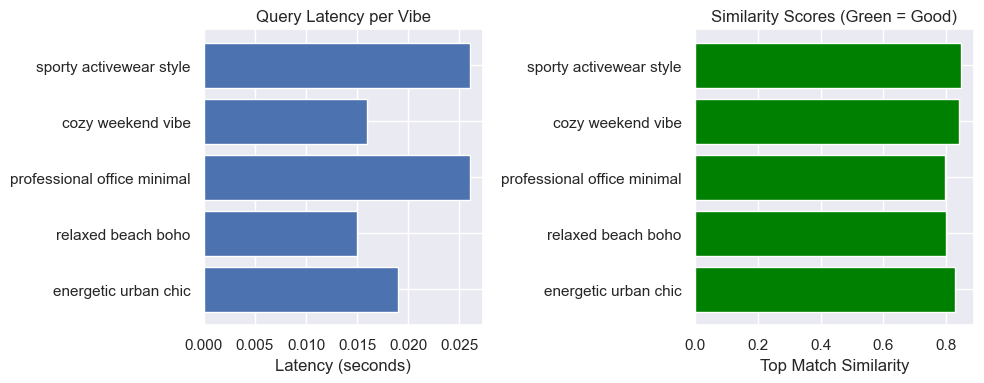


Average Latency: 0.020 seconds/query
Good Match Ratio: 100.0% of queries scored ≥ 0.7 similarity


In [13]:
plt.figure(figsize=(10, 4))

# Plot latency
plt.subplot(1, 2, 1)
plt.barh(res_df["query"], res_df["latency_sec"])
plt.xlabel("Latency (seconds)")
plt.title("Query Latency per Vibe")

# Plot similarity scores
plt.subplot(1, 2, 2)
colors = ["green" if good else "red" for good in res_df["good_match"]]
plt.barh(res_df["query"], res_df["score"], color=colors)
plt.xlabel("Top Match Similarity")
plt.title("Similarity Scores (Green = Good)")

plt.tight_layout()
plt.show()

avg_latency = res_df["latency_sec"].mean()
good_ratio = res_df["good_match"].mean() * 100

print(f"\nAverage Latency: {avg_latency:.3f} seconds/query")
print(f"Good Match Ratio: {good_ratio:.1f}% of queries scored ≥ 0.7 similarity")


**improvements**:
we can integrate vector databases where we can store all the descriptions
we can take user feedback and develop model based on it
we can use batch embedding along with caching to reduce repeated computation

**Edge cases handled**:
No Match Fallback: When the cosine similarity drops below 0.3, the system will return a “no strong match found” message rather than displaying irrelevant products. 
Dimension Mismatch Fix: We’ve added logic for shape normalization and flattening to automatically take care of 3D or batched embeddings.  Empty or Invalid Input: Any queries that are empty or invalid are caught before we create embeddings, preventing potential API or model errors.

**why AI at Nexora?**
At Nexora, AI a key part of our strategy that transforms subjective human preferences into clear, actionable insights. With AI, we can create truly personalized experiences, helping customers find items that resonate with them instead of just relying on keyword matches. This technology allows us to curate millions of products, reveal unique style combinations that customers might miss on their own, and learn from every interaction to enhance relevance and customer loyalty. More than just automation, AI sets us apart: it enables Nexora to provide emotionally intelligent recommendations, speed up the matching of products to customers, and streamline our merchandising and inventory planning. Plus, it opens up new revenue opportunities through premium personalization, shoppable experiences, and AI-driven design. 